# Анализ оценок текстовых файлов, полученных от LLM

## Импорт необходимых библиотек

In [1]:
import random

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from core.utils.visualization import *

Для воспроизводимости экспериментов

In [4]:
random.seed(42)
np.random.seed(42)

## Загрузка и анализ данных

In [5]:
data_path = 'output/estimated_texts.csv'

In [6]:
estimation_summary = pd.read_csv(data_path, index_col=0)
estimation_summary.sample(10)

,id,filename,content,size,rounded_size_kb,last_updated,already_evaluated,gemma2-9b-it,llama-3.1-70b-versatile,llama-3.3-70b-versatile,average_score
1550,1881,Преподавательский состав,"Баранова Оксана Викторовна\n\n, Кандидат химич...",1329,1,12-02-2020,True,3.0,4.0,4.0,3.666667
2218,2642,Школьнику (pupil) _ Page 6,«… человечество действительно нуждается\n\nв ч...,424,0,06-05-2020,True,2.0,2.0,3.0,2.333333
368,419,Горр Геннадий Викторович,Горр Геннадий Викторович\n\nДолжность:\n\nпроф...,6395,6,22-10-2020,True,4.0,3.0,4.0,3.666667
535,600,Достижения лицеистов,"Республиканский турнир юных математиков​\n\n""Т...",8291,8,27-04-2020,True,3.0,2.0,2.0,2.333333
1659,1993,Профессорско-преподавательский состав кафедры ...,Профессорско-преподавательский состав кафедры\...,1156,1,28-11-2019,True,3.0,4.0,3.0,3.333333
1487,1786,Поляков Виталий Юрьевич,Поляков Виталий Юрьевич\n\nДолжность:\n\nдоцен...,10566,10,03-06-2024,True,3.0,5.0,4.0,4.000000
1127,1329,Материалы конференции «Донецкие чтения» 2018,Материалы III Международной научной конференци...,1449,1,09-08-2019,True,2.0,2.0,2.0,2.000000
2193,2615,Чуфицкий Сергей Викторович,Чуфицкий Сергей Викторович\n\nДолжность:\n\nст...,5153,5,06-05-2019,True,3.0,4.0,4.0,3.666667
1535,1861,Практическая подготовка,Студенты кафедры журналистики в период обучени...,1462,1,05-12-2019,True,3.0,4.0,4.0,3.666667
1771,2125,Руководство университета,Ректор\n\nБеспалова Светлана Владимировна\n\nд...,2065,2,22-11-2024,True,3.0,3.0,4.0,3.333333


Посмотрим на число обработанных файлов

In [7]:
print(f"Всего было обработано файлов: {estimation_summary.shape[0]}")

Всего было обработано файлов: 2691


Проверим данные на наличие пропусков

In [8]:
estimation_summary.isna().sum()

id                         0
filename                   0
content                    0
size                       0
rounded_size_kb            0
last_updated               0
already_evaluated          0
gemma2-9b-it               0
llama-3.1-70b-versatile    0
llama-3.3-70b-versatile    0
average_score              0
dtype: int64

Пропущенных значений нет, значит оценка файлов с помощью LLM прошла корректно

Посмотрим на типы данных в датасете

In [9]:
estimation_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2691 entries, 0 to 2690
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2691 non-null   int64  
 1   filename                 2691 non-null   object 
 2   content                  2691 non-null   object 
 3   size                     2691 non-null   int64  
 4   rounded_size_kb          2691 non-null   int64  
 5   last_updated             2691 non-null   object 
 6   already_evaluated        2691 non-null   bool   
 7   gemma2-9b-it             2691 non-null   float64
 8   llama-3.1-70b-versatile  2691 non-null   float64
 9   llama-3.3-70b-versatile  2691 non-null   float64
 10  average_score            2691 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 233.9+ KB


В наборе данных содержатся как строковые, так и числовые типы данных, кроме того есть одна булевая метка, отражающая то, был ли файл действительно оценен моделями или же он просто получил высший балл за свой размер. Посмотрим на соотношение таких файлов

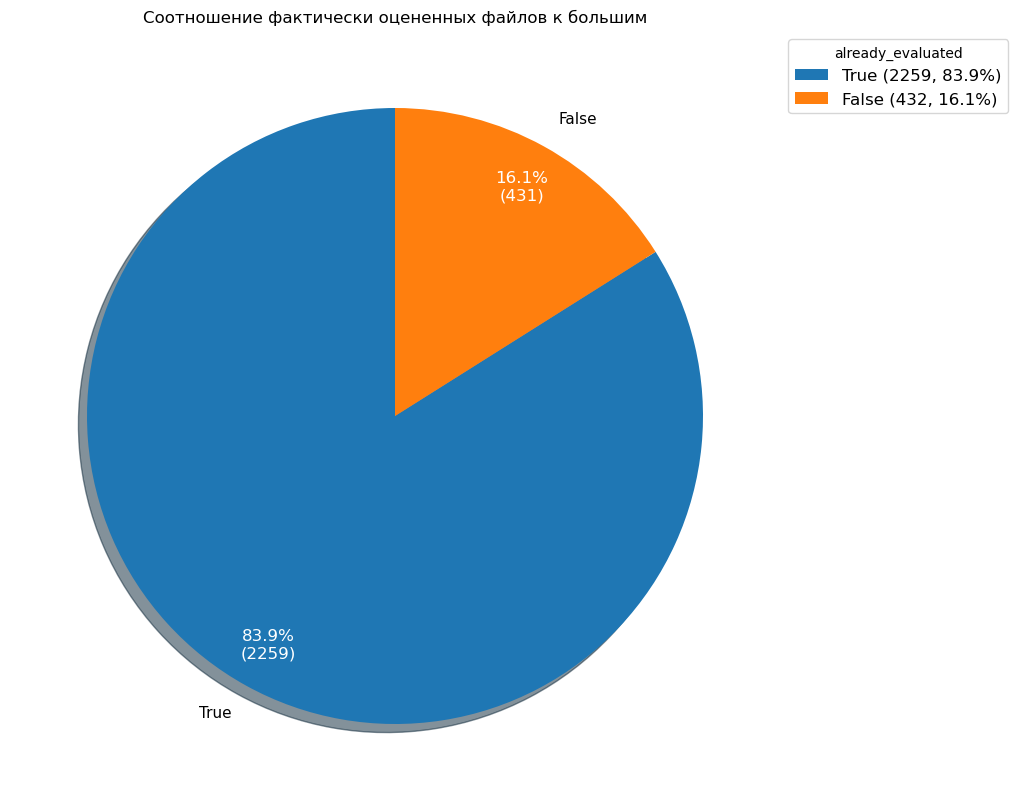

In [10]:
plot_pie_chart(estimation_summary, column='already_evaluated', title='Соотношение фактически оцененных файлов к большим')

Как видно, файлов, которые весят больше 11кб, около 20%, остальные же были оценены LLM, что является хорошим компромиссом между вычислительными ограничениями и качественным анализом файлов

Разделим набор данных на фактически оцененные файлы и файлы, получившие высший балл из-за своего размера (в данном случае  превышающие 11кб)

In [11]:
models_evaluated_df = estimation_summary[estimation_summary['already_evaluated']].copy()
pre_evaluated_df = estimation_summary[~estimation_summary['already_evaluated']]

print(f"Число оцененных файлов: {models_evaluated_df.shape[0]}")
print(f"Число больших файлов: {pre_evaluated_df.shape[0]}")

Число оцененных файлов: 2259
Число больших файлов: 432


Проверим состоятельность гипотезы о взаимосвязи размера файла и его оценки

Для этого построим матрицу корреляций оценок моделей и размера файла в килобайтах

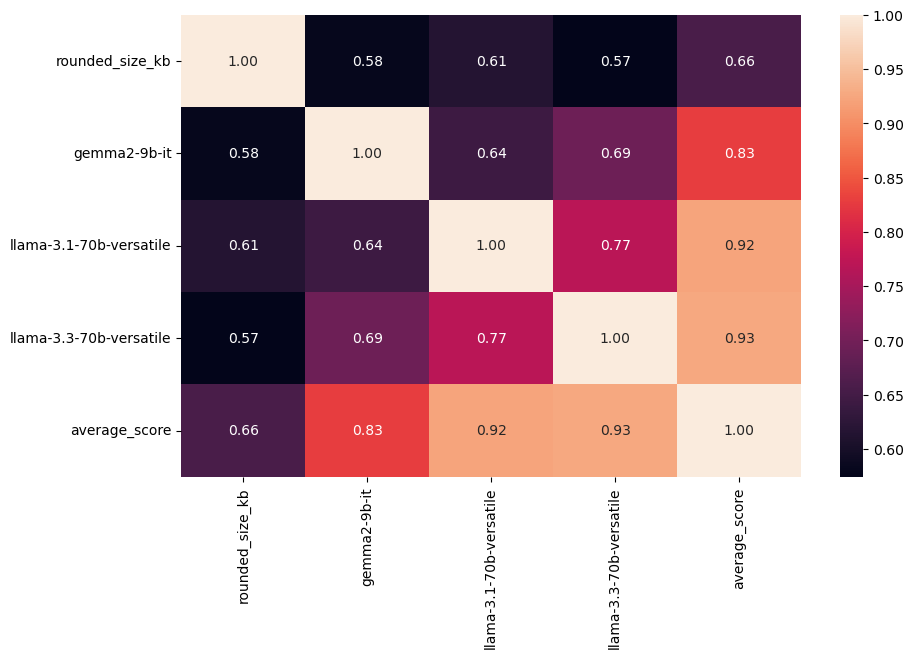

In [12]:
correlations = models_evaluated_df\
    .select_dtypes(include='number')\
    .drop(columns=['id', 'size'])\
    .corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.show()

Как видно, средняя оценка коррелирует с размером файла на 66%, что показывает наличие связи между данными показателями, причем данная корреляция является положительной. Это говорит о том, что с ростом размера файла будет расти и его оценка, а значит присвоение максимального балла файлам, превышающим некое пороговое значение по размеру оправдано

Также можно заметить, что на среднюю оценку в большей степени влияют оценки моделей семейства `llama`, что позволяет предположить их большую приспособленность для решения задачи оценки текстов 

Далее рассмотрим `реальные` оценки моделей

Выгрузим список моделей, участвовавших в оценке текстов

In [13]:
models_list_path = 'prompts/models_list.txt'

with open(models_list_path, 'r') as file:
    models = file.read().splitlines()
    
models

['gemma2-9b-it', 'llama-3.1-70b-versatile', 'llama-3.3-70b-versatile']

Построим гистограммы оценок каждой из них

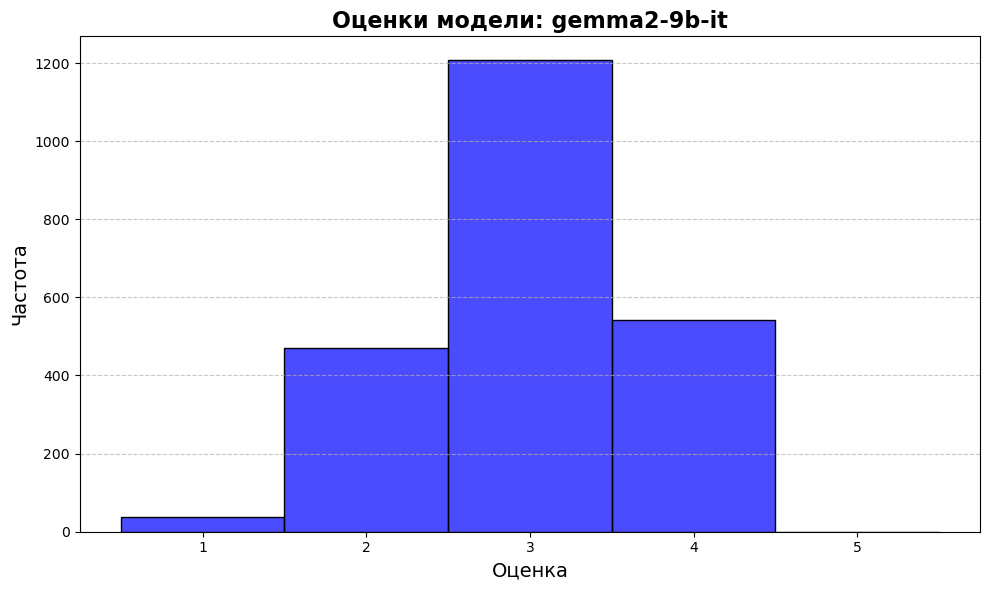

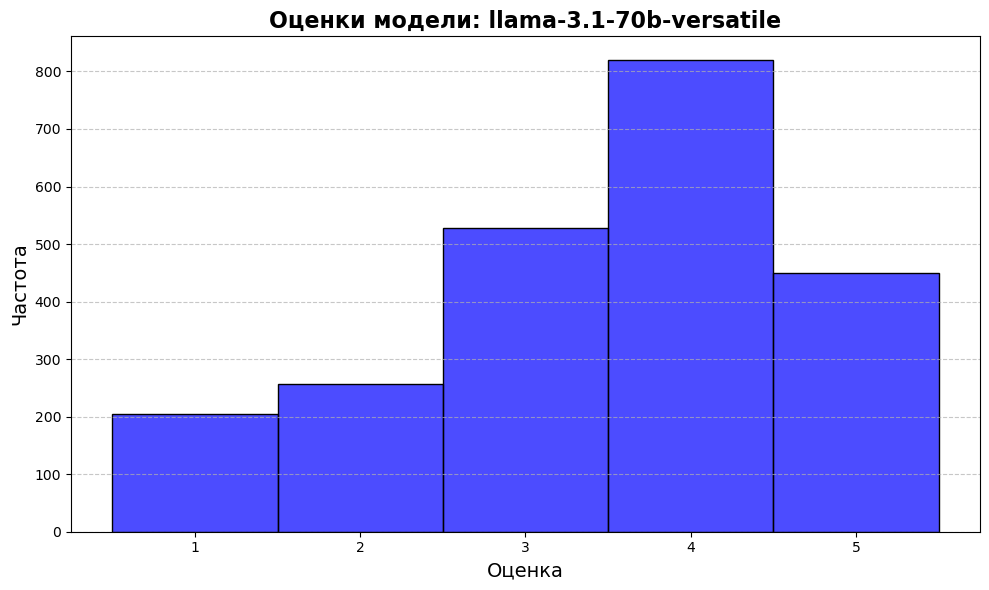

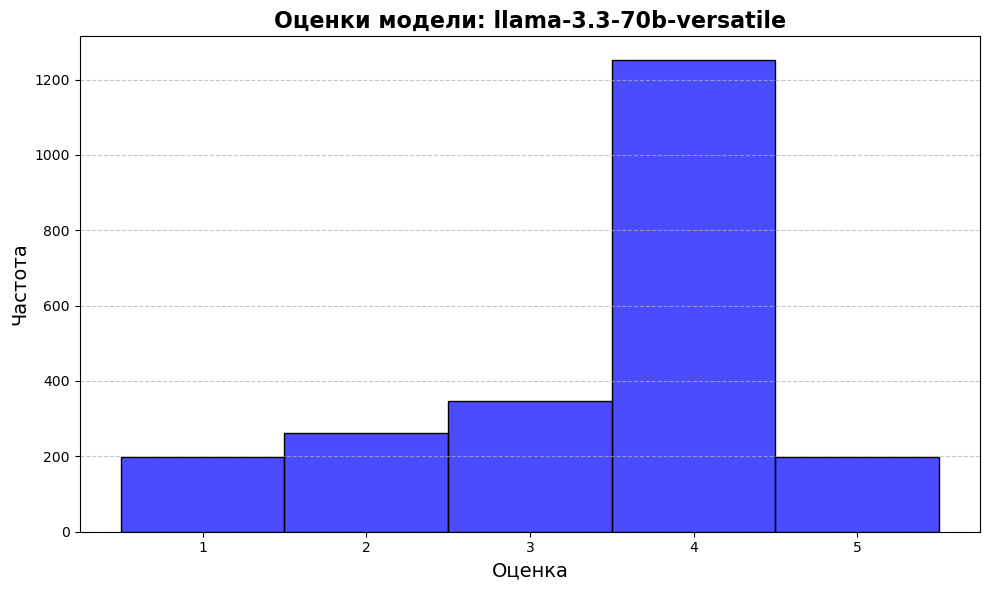

In [14]:
plot_evaluations_histograms(data=models_evaluated_df, models=models, integers_only=True)

Можно заметить, что распределения оценок моделей похожи на нормальные при смещении вправо, также интересен факт, что модель `gemma2-9b-it` ни разу не поставила оценку `5`

Модами распределений являются предпоследние по возрастанию оценки - `4` для моделей семейства `llama` и `3` для `gemma`, что дает право предположить о схожести суждений моделей и полноте анализа текстов, при использовании этих трех моделей

Также можно отметить, что модель `llama-3.3-70b-versatile` в большинстве случаев ставила четверки, в то время как `llama-3.1-70b-versatile` распределила большую часть оценок в промежутке от 3 до 5 с относительно небольшим преимуществом четверок

Оценим качество оценивания текстов моделями, вычислив максимальную разницу между оценками для каждого файла

In [15]:
models_evaluated_df['max_difference'] = abs(models_evaluated_df[models].max(axis=1) - models_evaluated_df[models].min(axis=1))
models_evaluated_df.sample(10)

,id,filename,content,size,rounded_size_kb,last_updated,already_evaluated,gemma2-9b-it,llama-3.1-70b-versatile,llama-3.3-70b-versatile,average_score,max_difference
151,167,Аннотации и ключевые слова,English\n\nАннотации и ключевые слова\n\n2023 ...,213,0,16-04-2024,True,1.0,1.0,2.0,1.333333,1.0
807,952,Кафедра биохимии и органической химии,Профессорско-преподавательский состав кафедры ...,6459,6,09-04-2019,True,3.0,4.0,4.0,3.666667,1.0
621,714,Информация для абитуриентов,"Бакалавриат\n\nКод\n\nНаправление подготовки, ...",4414,4,25-03-2022,True,4.0,5.0,4.0,4.333333,1.0
966,1142,Контакты физико-технического факультета,"Адрес для переписки: г. Донецк, ул.Университет...",494,0,21-05-2016,True,3.0,2.0,3.0,2.666667,1.0
1202,1429,Направления подготовки,Кафедра теории и истории государства и права\n...,654,1,13-01-2020,True,3.0,3.0,4.0,3.333333,1.0
1744,2094,Рецензирование статей,English\n\nПОРЯДОК РЕЦЕНЗИРОВАНИЯ РУКОПИСЕЙ НА...,4616,5,07-11-2023,True,3.0,4.0,4.0,3.666667,1.0
555,625,Емельянова Наталия Николаевна,Емельянова Наталия Николаевна\n\nДолжность:\n\...,4692,5,16-11-2020,True,3.0,5.0,4.0,4.000000,2.0
851,1005,Кафедра романской филологии,КАФЕДРА РОМАНСКОЙ ФИЛОЛОГИИ\n\nКафедра романск...,4851,5,20-09-2023,True,4.0,4.0,4.0,4.000000,0.0
1533,1859,Практическая подготовка,Практика является базовой частью основной обра...,11041,11,26-05-2018,True,3.0,5.0,4.0,4.000000,2.0
1281,1538,Научная деятельность физико-технического факул...,"К числу основных научных направлений, разрабат...",5419,5,28-04-2017,True,4.0,4.0,4.0,4.000000,0.0


Посмотрим, какие разницы в оценках моделей встречаются в наборе данных

In [16]:
models_evaluated_df.max_difference.value_counts()

max_difference
1.0    1476
0.0     400
2.0     369
3.0      14
Name: count, dtype: int64

Большая часть файлов имеет разницу в оценках, равную одному баллу, что нормально. Максимальный разброс составляет 3 балла, это вызывает определенный интерес, однако таких файлов всего `14` шт. Посмотрим на них

In [17]:
models_evaluated_df[models_evaluated_df.max_difference == 3]

,id,filename,content,size,rounded_size_kb,last_updated,already_evaluated,gemma2-9b-it,llama-3.1-70b-versatile,llama-3.3-70b-versatile,average_score,max_difference
24,26,Rules for authors,Русский\n\nRULES FOR AUTHORS\n\n1. The scienti...,5107,5,18-10-2024,True,2.0,5.0,4.0,3.666667,3.0
61,65,ud _ Page 32,Карпенко Евгения Николаевна\n\nДолжность:\n\nп...,3746,4,31-03-2019,True,3.0,5.0,2.0,3.333333,3.0
240,268,Борисов Дмитрий Анатольевич,Борисов Дмитрий Анатольевич\n\nДолжность:\n\nп...,4722,5,23-04-2019,True,3.0,1.0,4.0,2.666667,3.0
931,1107,Контакты,Директор ЦЭР\n\nНиколаев Юрий Борисович\n\niu....,316,0,18-09-2024,True,2.0,5.0,4.0,3.666667,3.0
941,1117,Контакты,Директор ЦЭР\n\nНиколаев Юрий Борисович\n\niu....,316,0,18-09-2024,True,2.0,5.0,4.0,3.666667,3.0
1358,1624,Образование _ Сведения об образовательной орга...,Информация о сроке действия государственной ак...,1648,2,18-09-2024,True,3.0,1.0,4.0,2.666667,3.0
1510,1813,Правила для авторов,English\n\nПРАВИЛА ДЛЯ АВТОРОВ\n\nВ сборник пр...,7879,8,05-07-2024,True,2.0,5.0,4.0,3.666667,3.0
1906,2293,Студенческое научное общество,Студенческое научное общество (СНО)\n\n– это о...,5368,5,18-04-2018,True,4.0,1.0,2.0,2.333333,3.0
1967,2372,Учебная деятельность,ФИО преподавателя\n\nДолжность\n\nСсылка на эл...,2958,3,16-10-2024,True,3.0,1.0,4.0,2.666667,3.0
1981,2387,Учебная деятельность,ГРАФИК\n\nучебного процесса очной формы обучен...,6446,6,08-10-2024,True,2.0,4.0,5.0,3.666667,3.0


Средние оценки файлов лежат в диапазоне от 2 до 4, наибольшие разбросы в оценки приносят модели `gemma2-9b-it` и `llama-3.1-70b-versatile`, что позволяет предоположить что модель `llama-3.3-70b-versatile` является наиболее устойчивой для решения задачи оценки текстов

После просмотра содержимого "спорных" файлов вручную можно убедиться что в целом все они (даже файлы с наименьшей средней оценкой, равной `2.33`) подходят для генерации инструкций, поэтому исключать их не будем

## Исключение "нерелевантных" файлов из последующего исследования

Построим гистограмму распределения средних оценок файлов

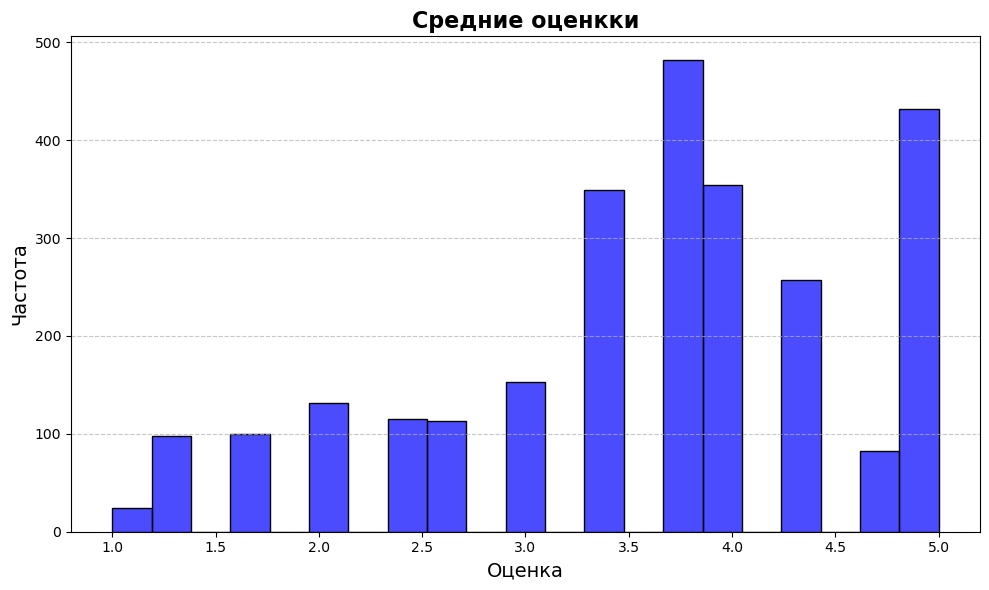

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(estimation_summary['average_score'], color="blue", edgecolor="black", alpha=0.7)
plt.title(f"Средние оценкки", fontsize=16, fontweight='bold')
plt.xlabel("Оценка", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Как видно, большая часть оценок сосредоточена в промежутке от 3 до 5, что говорит об удовлетворительном качестве выгруженных файлов в контексте построения instruction dataset и дообучения LLM интеллектуального ассистента

Посмотрим на средние оценки в табличном представлении

In [19]:
scores_counts = estimation_summary.average_score.value_counts().to_frame().sort_values(by='average_score', ascending=False)
scores_counts['cummulative count'] = scores_counts.cumsum()
scores_counts

,count,cummulative count
average_score,,
5.000000,432,432
4.666667,82,514
4.333333,257,771
4.000000,354,1125
3.666667,482,1607
3.333333,349,1956
3.000000,153,2109
2.666667,113,2222
2.333333,115,2337


Мы добавили колонку `cummulative count`, чтобы отобразить, сколько файлов будет отправлено для построения instruction dataset в случае отсечения файлов со средней оценкой ниже заданной

Так, если мы исключим файлы с оценкой `2.0` и ниже, то у нас останется `2337` файлов, что может быть достаточно для построения instruction dataset, пригодного к использованию для дообучения LLM интеллектуального ассистента

Выбор такой пороговой оценки обусловлен и тем фактом, что при рассмотрении "спорных файлов" файлы, имеющие оценку `2.33` являются вполне пригодными для генерации инструкций, кроме того средняя оценка свыше `2.0` говорит о том, что как минимум одна LLM оценила данный файл меткой `3.0` или выше, что говорит о пригодности файла для создания instruction dataset

Выделим из набора данных файлы, чья средняя оценка превышает `2.0`

In [20]:
relevant_texts = estimation_summary[estimation_summary['average_score'] > 2]
relevant_texts.sample(10)

,id,filename,content,size,rounded_size_kb,last_updated,already_evaluated,gemma2-9b-it,llama-3.1-70b-versatile,llama-3.3-70b-versatile,average_score
191,210,Балакирева Елизавета Анатольевна,Балакирева Елизавета Анатольевна\n\nДолжность:...,8254,8,17-01-2022,True,4.0,4.0,4.0,4.000000
1262,1510,Научная деятельность,Научная деятельность кафедры английского языка...,7218,7,12-11-2024,True,4.0,4.0,4.0,4.000000
2265,114,«Историческая память о Великой Победе как осно...,МАТЕРИАЛЫ\n\nМеждународной научно-практической...,32527,32,04-06-2021,False,5.0,5.0,5.0,5.000000
883,1044,Квашина Людмила Павловна,Квашина Людмила Павловна\n\nДолжность:\n\nДоце...,8511,8,23-04-2024,True,4.0,4.0,5.0,4.333333
2239,2665,Электронно-библиотечная система,Электронно-библиотечная система\n\nБД\n\nОписа...,8815,9,13-10-2024,True,3.0,4.0,4.0,3.666667
1129,1331,Материалы форума,"Том 1: Механико-математические, компьютерные и...",1314,1,30-06-2022,True,2.0,3.0,3.0,2.666667
1331,1595,Носко Карина Геннадиевна,Носко Карина Геннадиевна\n\nДолжность:\n\nСтар...,7103,7,23-04-2024,True,4.0,4.0,4.0,4.000000
615,708,Информационно-аналитический отдел,Информационно-аналитический отдел\n\nсоздан пр...,4341,4,13-02-2017,True,3.0,4.0,4.0,3.666667
2193,2615,Чуфицкий Сергей Викторович,Чуфицкий Сергей Викторович\n\nДолжность:\n\nст...,5153,5,06-05-2019,True,3.0,4.0,4.0,3.666667
1520,1838,Правила оформления тезисов,ТРЕБОВАНИЯ К ОФОРМЛЕНИЮ ТЕЗИСОВ\n\nМатериалы д...,2745,3,17-08-2021,True,4.0,5.0,4.0,4.333333


Посмотрим на число релевантных файлов

In [21]:
print(f"Выделено релевантных файлов: {relevant_texts.shape[0]}")

Выделено релевантных файлов: 2337


Если LLM будет генерировать в среднем по 5 инструкций на 1 файл, то в результате у нас получится instruction dataset на более чем `11 тыс.` пар инструкция-ответ, что вполне достаточно для дообучения LLM корпоративного интеллектуального ассистента 

Сохраним записи о релевантных текстовых файлах в csv

In [22]:
relevant_texts.to_csv('output/relevant_texts.csv')
print("Данные успешно сохранены")

Данные успешно сохранены
